In [1]:
import os
import pymysql
import pandas as pd
import sys


import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

In [2]:
df_bike = pd.read_csv("availability.csv")
df_bike.head(10)

,number,last_update,available_bikes,available_bike_stands,status
0,11,01/02/2022 00:00,22,8,OPEN
1,39,01/02/2022 00:00,5,15,OPEN
2,42,01/02/2022 00:00,22,8,OPEN
3,13,01/02/2022 00:00,22,8,OPEN
4,88,01/02/2022 00:00,19,11,OPEN
5,7,01/02/2022 00:00,7,22,OPEN
6,3,01/02/2022 00:00,12,8,OPEN
7,71,01/02/2022 00:00,33,7,OPEN
8,38,01/02/2022 00:00,26,14,OPEN
9,90,01/02/2022 00:00,11,29,OPEN


In [3]:
df_weather = pd.read_csv("current.csv")
df_weather.head(10)

,dt,feels_like,humidity,pressure,sunrise,sunset,temp,uvi,weather_id,wind_gust,wind_speed,rain_1h,snow_1h
0,01/02/2022 00:30,279.62,83,1024,01/02/2022 08:09,01/02/2022 17:07,282.61,0.0,803,14.75,6.26,0.0,0.0
1,01/02/2022 01:00,279.61,84,1024,01/02/2022 08:09,01/02/2022 17:07,282.60,0.0,803,13.41,6.26,0.0,0.0
2,01/02/2022 01:30,279.34,86,1024,01/02/2022 08:09,01/02/2022 17:07,282.60,0.0,803,13.41,7.15,0.0,0.0
3,01/02/2022 02:00,279.21,87,1024,01/02/2022 08:09,01/02/2022 17:07,282.60,0.0,803,12.96,7.60,0.0,0.0
4,01/02/2022 02:30,279.38,90,1024,01/02/2022 08:09,01/02/2022 17:07,282.42,0.0,300,12.52,6.26,0.0,0.0
5,01/02/2022 03:00,278.98,91,1024,01/02/2022 08:09,01/02/2022 17:07,282.11,0.0,300,12.07,6.26,0.0,0.0
6,01/02/2022 03:30,278.85,92,1024,01/02/2022 08:09,01/02/2022 17:07,282.22,0.0,300,14.75,7.15,0.0,0.0
7,01/02/2022 04:00,278.77,92,1023,01/02/2022 08:09,01/02/2022 17:07,282.26,0.0,300,14.75,7.60,0.0,0.0
8,01/02/2022 04:30,278.94,92,1023,01/02/2022 08:09,01/02/2022 17:07,282.39,0.0,300,12.96,7.60,0.0,0.0
9,01/02/2022 05:30,279.46,95,1023,01/02/2022 08:09,01/02/2022 17:07,282.59,0.0,300,12.52,6.71,0.0,0.0


# Prepare Data

In [4]:
# Bikes data
df_bike['last_update'].describe().T
df_bike.drop_duplicates(subset=['last_update'], keep='first', inplace=True)
df_bike['last_update'].describe().T

# Weather data
df_weather['dt'].describe().T
df_weather.drop_duplicates(subset=['dt'], keep='first', inplace=True)
df_weather['dt'].describe().T

df_bike.shape
df_weather.shape

(2141, 13)

In [5]:
df_bike['last_update'] = pd.to_datetime(df_bike['last_update'])
df_weather['dt'] = pd.to_datetime(df_weather['dt'])

In [6]:
df_weather['weather_id'] = df_weather['weather_id'].astype('object')

In [7]:
categoric_columns = df_weather[['weather_id']].columns

In [8]:
item_counts = df_weather["weather_id"].value_counts()
print(item_counts)

803    987
801    422
802    299
800    119
500     88
501     60
300     58
741     30
701     22
804     21
520     18
502      9
310      5
620      1
600      1
721      1
Name: weather_id, dtype: int64


In [9]:
df_weather['weather_id'].replace(300,'light intensity drizzle', inplace = True)
df_weather['weather_id'].replace(310,'light intensity drizzle rain', inplace = True)
df_weather['weather_id'].replace(500,'light rain', inplace = True)
df_weather['weather_id'].replace(501,'moderate rain', inplace = True)
df_weather['weather_id'].replace(502,'heavy intensity rain', inplace = True)
df_weather['weather_id'].replace(520,'light intensity shower rain', inplace = True)
df_weather['weather_id'].replace(600,'light snow', inplace = True)
df_weather['weather_id'].replace(620,'light shower snow', inplace = True)
df_weather['weather_id'].replace(701,'mist', inplace = True)
df_weather['weather_id'].replace(721,'haze', inplace = True)
df_weather['weather_id'].replace(741,'fog', inplace = True)
df_weather['weather_id'].replace(800,'clear sky', inplace = True)
df_weather['weather_id'].replace(801,'few clouds', inplace = True)
df_weather['weather_id'].replace(802,'scattered clouds', inplace = True)
df_weather['weather_id'].replace(803,'broken clouds', inplace = True)
df_weather['weather_id'].replace(804,'overcast clouds', inplace = True)

In [10]:
## reference: https://gist.github.com/tbranyen/62d974681dea8ee0caa1

In [11]:
df_weather.head(10)

,dt,feels_like,humidity,pressure,sunrise,sunset,temp,uvi,weather_id,wind_gust,wind_speed,rain_1h,snow_1h
0,2022-01-02 00:30:00,279.62,83,1024,01/02/2022 08:09,01/02/2022 17:07,282.61,0.0,broken clouds,14.75,6.26,0.0,0.0
1,2022-01-02 01:00:00,279.61,84,1024,01/02/2022 08:09,01/02/2022 17:07,282.60,0.0,broken clouds,13.41,6.26,0.0,0.0
2,2022-01-02 01:30:00,279.34,86,1024,01/02/2022 08:09,01/02/2022 17:07,282.60,0.0,broken clouds,13.41,7.15,0.0,0.0
3,2022-01-02 02:00:00,279.21,87,1024,01/02/2022 08:09,01/02/2022 17:07,282.60,0.0,broken clouds,12.96,7.60,0.0,0.0
4,2022-01-02 02:30:00,279.38,90,1024,01/02/2022 08:09,01/02/2022 17:07,282.42,0.0,light intensity drizzle,12.52,6.26,0.0,0.0
5,2022-01-02 03:00:00,278.98,91,1024,01/02/2022 08:09,01/02/2022 17:07,282.11,0.0,light intensity drizzle,12.07,6.26,0.0,0.0
6,2022-01-02 03:30:00,278.85,92,1024,01/02/2022 08:09,01/02/2022 17:07,282.22,0.0,light intensity drizzle,14.75,7.15,0.0,0.0
7,2022-01-02 04:00:00,278.77,92,1023,01/02/2022 08:09,01/02/2022 17:07,282.26,0.0,light intensity drizzle,14.75,7.60,0.0,0.0
8,2022-01-02 04:30:00,278.94,92,1023,01/02/2022 08:09,01/02/2022 17:07,282.39,0.0,light intensity drizzle,12.96,7.60,0.0,0.0
9,2022-01-02 05:30:00,279.46,95,1023,01/02/2022 08:09,01/02/2022 17:07,282.59,0.0,light intensity drizzle,12.52,6.71,0.0,0.0


In [12]:

df_bike.rename(columns={'last_update':'dt'}, inplace=True)
df_bike['dt_hour'] = df_bike['dt'].dt.hour
df_bike['dt_min'] = df_bike['dt'].dt.minute
df_bike['dt_date'] = df_bike['dt'].dt.date
# The day of the week with Monday=0, Sunday=6.
df_bike['dt_dayofweek'] = df_bike['dt'].dt.dayofweek
df_weather['dt_hour'] = df_weather['dt'].dt.hour
df_weather['dt_min'] = df_weather['dt'].dt.minute
df_weather['dt_date'] = df_weather['dt'].dt.date

In [13]:
# Merge dataframes
df_merged = pd.merge(df_bike, df_weather, on = ['dt_min', 'dt_date', 'dt_hour'], how = 'inner')
# Show first 2 scraps (oldest) for stations (113*2=226)
df_merged.dtypes

number                            int64
dt_x                     datetime64[ns]
available_bikes                   int64
available_bike_stands             int64
status                           object
dt_hour                           int64
dt_min                            int64
dt_date                          object
dt_dayofweek                      int64
dt_y                     datetime64[ns]
feels_like                      float64
humidity                          int64
pressure                          int64
sunrise                          object
sunset                           object
temp                            float64
uvi                             float64
weather_id                       object
wind_gust                       float64
wind_speed                      float64
rain_1h                         float64
snow_1h                         float64
dtype: object

In [14]:
# Select columns containing categorical data
categorical_columns = df_merged[['weather_id']].columns

In [15]:

# Select columns containing continuous data
continuous_columns = df_merged[['number', 'available_bike_stands', 'available_bikes', 'dt_hour', 'dt_min', 'dt_dayofweek', 
                         'temp', 'feels_like', 'wind_speed']].columns
# Print table
df_merged[continuous_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
number,1584.0,60.356692,33.656391,2.00,31.0000,60.000,89.0000,117.00
available_bike_stands,1584.0,18.825758,10.129481,0.00,12.0000,19.000,27.0000,40.00
available_bikes,1584.0,12.956439,8.804825,0.00,6.0000,12.000,19.0000,40.00
dt_hour,1584.0,13.435606,5.965230,0.00,8.0000,13.000,19.0000,23.00
dt_min,1584.0,15.355429,15.007113,0.00,0.0000,30.000,30.0000,32.00
dt_dayofweek,1584.0,3.053030,2.052616,0.00,1.0000,3.000,5.0000,6.00
temp,1584.0,280.960473,3.031156,272.59,278.9175,281.065,282.6925,289.62
feels_like,1584.0,278.155808,4.209198,267.29,275.3250,278.005,280.6425,288.81
wind_speed,1584.0,6.127191,3.070325,0.00,4.0200,5.660,7.8025,19.55


/var/folders/9r/pt_53l_55hnfbqs4389kw3h40000gn/T/ipykernel_70285/3204442930.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'number'),
  Text(1.5, 0, 'available_bike_stands'),
  Text(2.5, 0, 'available_bikes'),
  Text(3.5, 0, 'dt_hour'),
  Text(4.5, 0, 'dt_min'),
  Text(5.5, 0, 'dt_dayofweek'),
  Text(6.5, 0, 'temp'),
  Text(7.5, 0, 'feels_like'),
  Text(8.5, 0, 'wind_speed')])

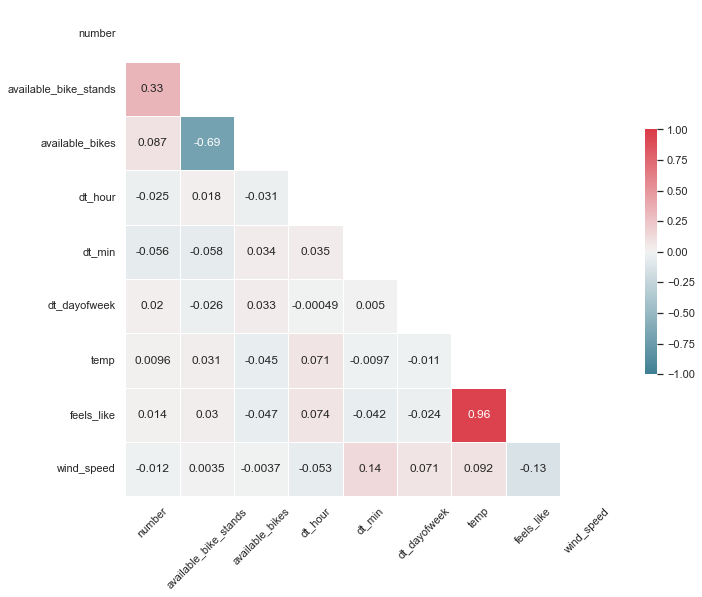

In [16]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = df_merged[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 45)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

<AxesSubplot:xlabel='available_bike_stands', ylabel='dt_dayofweek'>

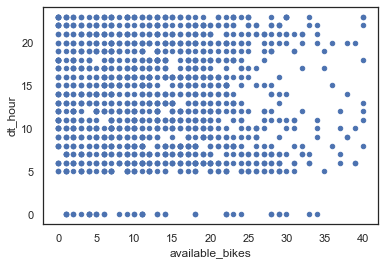

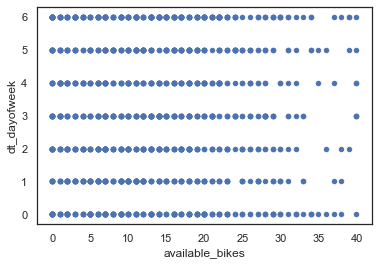

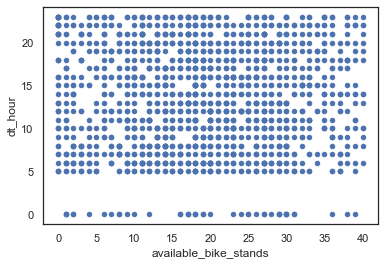

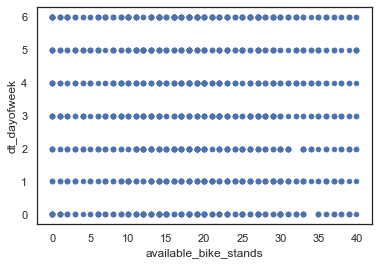

In [17]:
df_merged.plot(kind='scatter', x='available_bikes', y='dt_hour')
df_merged.plot(kind='scatter', x='available_bikes', y='dt_dayofweek')
df_merged.plot(kind='scatter', x='available_bike_stands', y='dt_hour')
df_merged.plot(kind='scatter', x='available_bike_stands', y='dt_dayofweek')

<AxesSubplot:title={'center':'available_bike_stands'}, xlabel='[weather_id]'>

<Figure size 432x288 with 0 Axes>

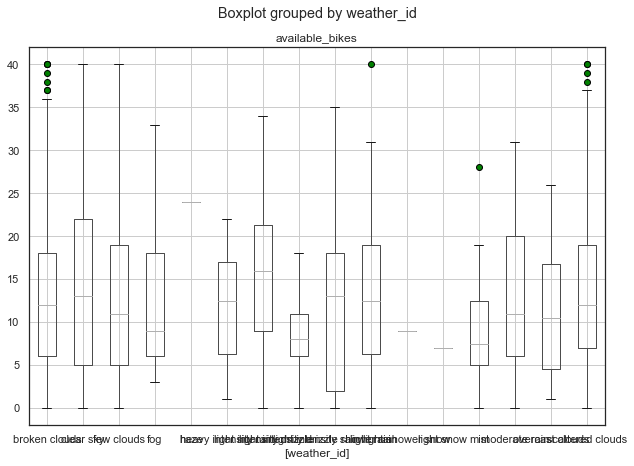

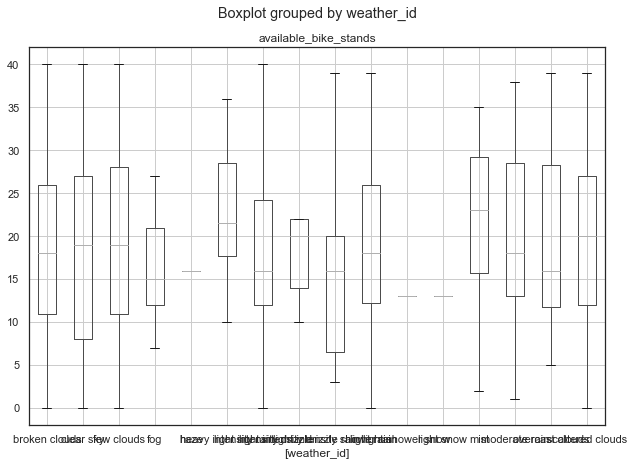

In [18]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df_merged.boxplot(column=['available_bikes'], by=['weather_id'], flierprops=flierprops, figsize=(10,7))
df_merged.boxplot(column=['available_bike_stands'], by=['weather_id'], flierprops=flierprops, figsize=(10,7))

In [19]:
df_station_3 = df_bike[df_bike['number']==3]
#df_bike['number'] == 3
df_station_3.head()

,number,dt,available_bikes,available_bike_stands,status,dt_hour,dt_min,dt_date,dt_dayofweek
494,3,2022-01-02 05:03:00,11,9,OPEN,5,3,2022-01-02,6
601,3,2022-01-02 05:13:00,11,9,OPEN,5,13,2022-01-02,6
710,3,2022-01-02 05:23:00,11,9,OPEN,5,23,2022-01-02,6
822,3,2022-01-02 05:33:00,11,9,OPEN,5,33,2022-01-02,6
1074,3,2022-01-02 05:57:00,9,11,OPEN,5,57,2022-01-02,6


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

<AxesSubplot:xlabel='dt_dayofweek', ylabel='available_bike_stands'>

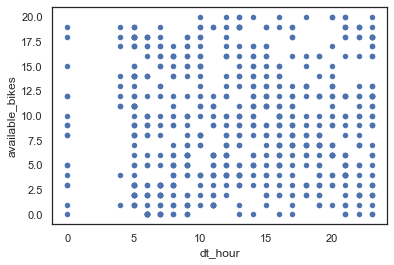

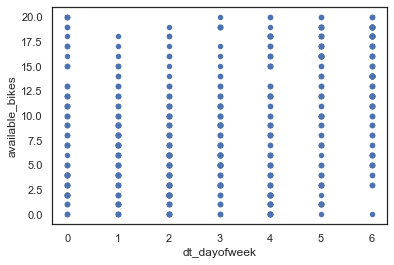

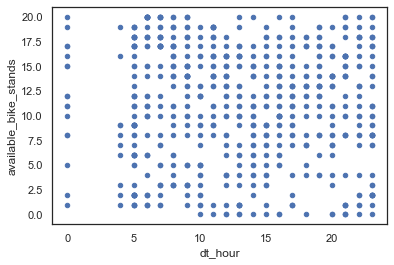

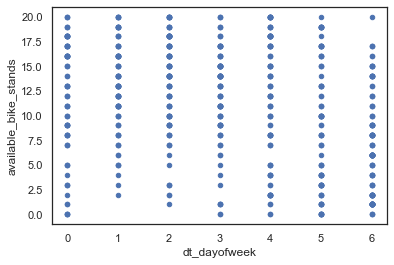

In [20]:
df_station_3.plot(kind='scatter', x='dt_hour', y='available_bikes')
df_station_3.plot(kind='scatter', x='dt_dayofweek', y='available_bikes')
df_station_3.plot(kind='scatter', x='dt_hour', y='available_bike_stands')
df_station_3.plot(kind='scatter', x='dt_dayofweek', y='available_bike_stands')

In [21]:
df_station_3 = df_merged[df_merged['number']==3]
#df_bike['number'] == 3
df_station_3.head()

,number,dt_x,available_bikes,available_bike_stands,status,dt_hour,dt_min,dt_date,dt_dayofweek,dt_y,...,pressure,sunrise,sunset,temp,uvi,weather_id,wind_gust,wind_speed,rain_1h,snow_1h
96,3,2022-05-02 09:30:00,0,20,OPEN,9,30,2022-05-02,0,2022-05-02 09:30:00,...,1012,05/02/2022 08:03,05/02/2022 17:15,280.63,0.07,broken clouds,14.31,9.39,0.0,0.0
436,3,2022-02-18 13:00:00,3,17,OPEN,13,0,2022-02-18,4,2022-02-18 13:00:00,...,992,18/02/2022 07:37,18/02/2022 17:40,278.08,0.92,scattered clouds,22.80,17.43,0.0,0.0
446,3,2022-02-18 19:30:00,2,18,OPEN,19,30,2022-02-18,4,2022-02-18 19:30:00,...,1003,18/02/2022 07:37,18/02/2022 17:40,275.34,0.00,few clouds,0.00,8.23,0.0,0.0
638,3,2022-02-25 16:30:00,6,14,OPEN,16,30,2022-02-25,4,2022-02-25 16:30:00,...,1025,25/02/2022 07:22,25/02/2022 17:54,283.75,0.00,broken clouds,0.00,6.17,0.0,0.0
676,3,2022-02-27 07:30:00,15,5,OPEN,7,30,2022-02-27,6,2022-02-27 07:30:00,...,1015,27/02/2022 07:17,27/02/2022 17:58,280.57,0.12,broken clouds,0.00,7.72,0.0,0.0


<AxesSubplot:title={'center':'available_bike_stands'}, xlabel='[weather_id]'>

<Figure size 432x288 with 0 Axes>

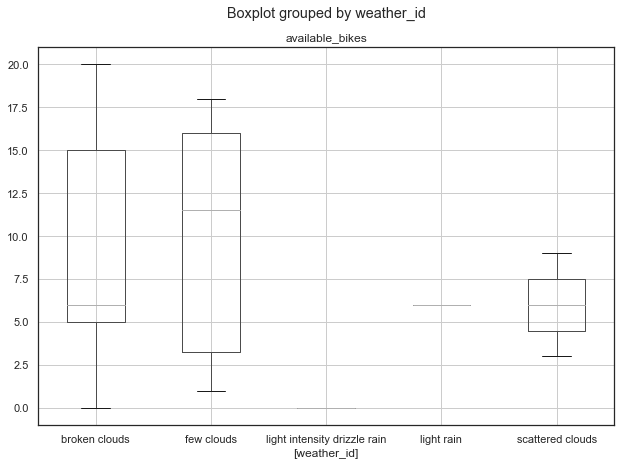

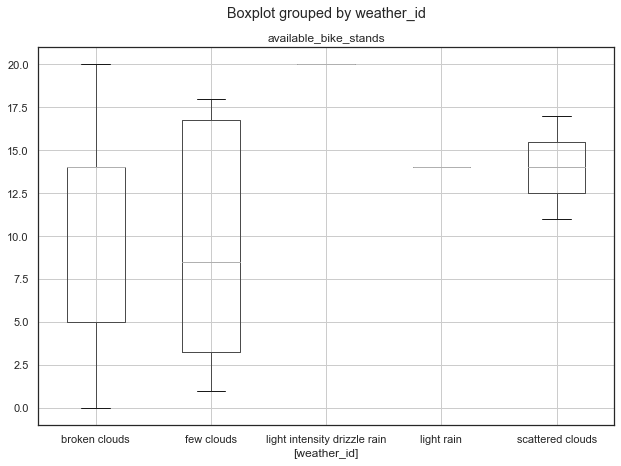

In [22]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df_station_3.boxplot(column=['available_bikes'], by=['weather_id'], flierprops=flierprops, figsize=(10,7))
df_station_3.boxplot(column=['available_bike_stands'], by=['weather_id'], flierprops=flierprops, figsize=(10,7))

In [23]:
df_station_3['scattered clouds'] = df_station_3.weather_id.apply(lambda x: 1 if 'scattered clouds' in x else 0)
df_merged['scattered clouds'] = df_merged.weather_id.apply(lambda x: 1 if 'scattered clouds' in x else 0)

/var/folders/9r/pt_53l_55hnfbqs4389kw3h40000gn/T/ipykernel_70285/1072845553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station_3['scattered clouds'] = df_station_3.weather_id.apply(lambda x: 1 if 'scattered clouds' in x else 0)


# ML Model

In [24]:
# Select model features and store them in a new dataframe
input_data = pd.DataFrame(df_station_3[['dt_dayofweek', 'dt_hour', 'scattered clouds']])

# Define target variable
output_data = df_station_3['available_bikes']

# Split dataset to train and test
x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.25, random_state=42)
print("Training the model on %s rows and %s columns." % x_train.shape)

lr = LinearRegression()

# Train the model
lr.fit(x_train, y_train)

print("Testing the model on %s rows." % y_test.shape[0])

Training the model on 14 rows and 3 columns.
Testing the model on 5 rows.


In [25]:
df_station_3.dtypes

number                            int64
dt_x                     datetime64[ns]
available_bikes                   int64
available_bike_stands             int64
status                           object
dt_hour                           int64
dt_min                            int64
dt_date                          object
dt_dayofweek                      int64
dt_y                     datetime64[ns]
feels_like                      float64
humidity                          int64
pressure                          int64
sunrise                          object
sunset                           object
temp                            float64
uvi                             float64
weather_id                       object
wind_gust                       float64
wind_speed                      float64
rain_1h                         float64
snow_1h                         float64
scattered clouds                  int64
dtype: object

In [26]:
# Get prediction for test cases
prediction = lr.predict(x_test)

# Show the predicted test cases
print(prediction)
print(y_test)

[-4.66464537 -6.24195994  7.22430969 12.24266378 -5.19041689]
96       0
703     18
1203    16
436      3
957      5
Name: available_bikes, dtype: int64


In [27]:
print("RMSE: %f" % np.sqrt(metrics.mean_squared_error(y_test, prediction)))

RMSE: 13.234166


In [34]:
import pickle

id_list = list(df_merged['number'].unique())
for station_id in id_list:
    df_station = df_merged[df_merged['number']==station_id]
    
    # Select model features and store them in a new dataframe
    input_data = pd.DataFrame(df_station[['dt_dayofweek', 'dt_hour', 'scattered clouds']])

    # Define target variable
    output_data = df_station['available_bikes']

    # Split dataset to train and test
    x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.25, random_state=3)

    lr = LinearRegression()

    # Train the model
    lr.fit(x_train, y_train)
    
    with open('/Users/air/Desktop/models/ ' + str(station_id) + '_station_model.pkl', 'wb') as handle:
        pickle.dump(lr, handle, pickle.HIGHEST_PROTOCOL)

In [37]:
import pickle

with open('model/ 3_station_model.pkl', 'rb') as f:
    data = pickle.load(f)
data

LinearRegression()

In [39]:
import pickle  
f = open('model/ 3_station_model.pkl','rb')  
info = pickle.load(f)  
info 

LinearRegression()